In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install micromlgen
from micromlgen import port
import os

  Preparing metadata (setup.py) ... done
  Created wheel for micromlgen: filename=micromlgen-1.1.28-py3-none-any.whl size=32153 sha256=f6c19ec96b9cfbd117416edce6c0aedde48f082050cc5f263d87f95855398da8
  Stored in directory: /root/.cache/pip/wheels/97/54/64/5d82c310920abe1be0d120313ceb9e12c88f5701f53f6ed248
Successfully built micromlgen


In [ ]:
file_path = 'dataset_plus_idle.csv'
dataset = pd.read_csv(file_path)

In [ ]:
label_mapping = {'benar': 0, 'salah': 1, 'idle': 2}
dataset['Label'] = dataset['Label'].map(label_mapping)

In [ ]:
X = dataset[['ax1', 'ay1', 'az1', 'gx1', 'gy1', 'gz1', 'ax2', 'ay2', 'az2', 'gx2', 'gy2', 'gz2']]
y = dataset['Label']

In [ ]:
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

In [ ]:
model = SVC(random_state=42)

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000, 10000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf', 'poly']
}

In [ ]:
grid = GridSearchCV(model, param_grid, refit=True, verbose=3, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
grid.fit(X_normalized, y)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.960 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.937 total time=   0.1s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.961 total time=   0.1s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.948 total time=   0.1s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.992 total time=   0.1s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.975 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.952 total time=   0.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.980 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.955 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.986 total time=   0.1s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.975 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf', 'poly']},
             verbose=3)

In [ ]:
best_params = grid.best_params_
print("\nParameter terbaik dari GridSearchCV:", best_params)


Parameter terbaik dari GridSearchCV: {'C': 10000, 'gamma': 1, 'kernel': 'rbf'}


In [ ]:
best_model = SVC(random_state=42, **best_params)

In [ ]:
best_model = grid.best_estimator_

In [ ]:
cv_results = cross_validate(best_model, X_normalized, y,
                            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                            scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])

print("\nHasil Cross-Validation:")
print("Accuracy:", np.mean(cv_results['test_accuracy']))
print("Precision:", np.mean(cv_results['test_precision_weighted']))
print("Recall:", np.mean(cv_results['test_recall_weighted']))
print("F1 Score:", np.mean(cv_results['test_f1_weighted']))


Hasil Cross-Validation:
Accuracy: 0.9913665848694098
Precision: 0.9916353332794628
Recall: 0.9913665848694098
F1 Score: 0.9913357109115152


In [ ]:
y_pred_cv = grid.predict(X_normalized)
conf_matrix = confusion_matrix(y, y_pred_cv)

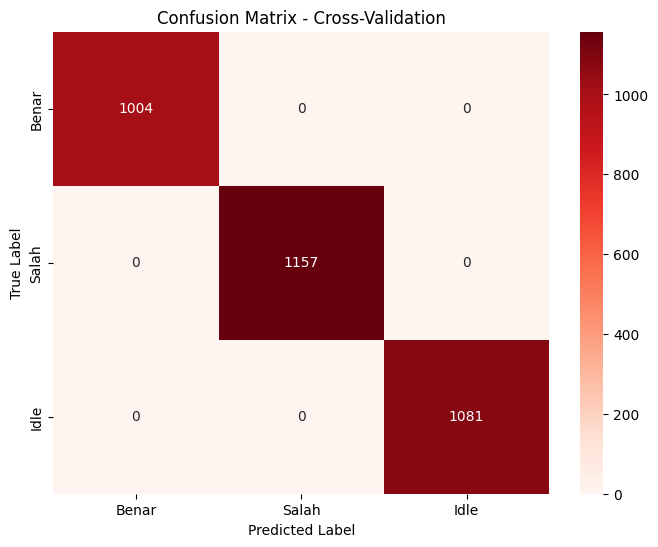

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benar', 'Salah', 'Idle'],
            yticklabels=['Benar', 'Salah', 'Idle'])
plt.title("Confusion Matrix - Cross-Validation")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
if best_model.kernel != 'linear':
    best_model.gamma = float(best_model.get_params().get('gamma', 0.001))

header = port(best_model, classname='DeadliftSVM')

model_file_path = 'withgyro_svm_model_minmax_scaler.h'
with open(model_file_path, 'w') as f:
    f.write(header)

print("Model berhasil disimpan ke 'withgyro_svm_model_minmax_scaler.h'")

file_size = os.stat(model_file_path).st_size

print(f"Ukuran model SVM dalam file '.h': {file_size / 1024:.2f} KB")

Model berhasil disimpan ke 'withgyro_svm_model_minmax_scaler.h'
Ukuran model SVM dalam file '.h': 23.34 KB
